In [1]:
import probability

import math, random, json, time
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Running seed 9000
Running seed 9013
Running seed 9026
Running seed 9039
Elapsed 22.352641582489014


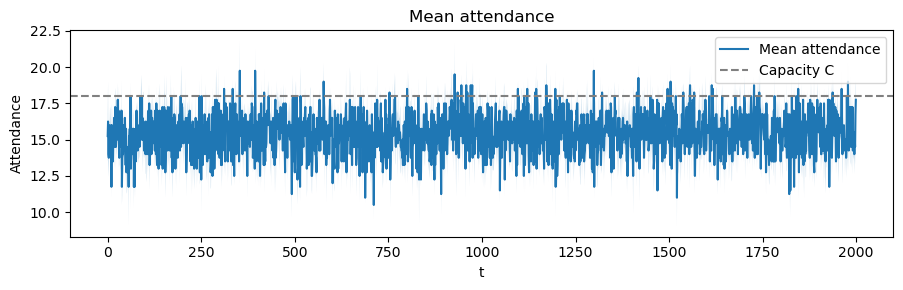

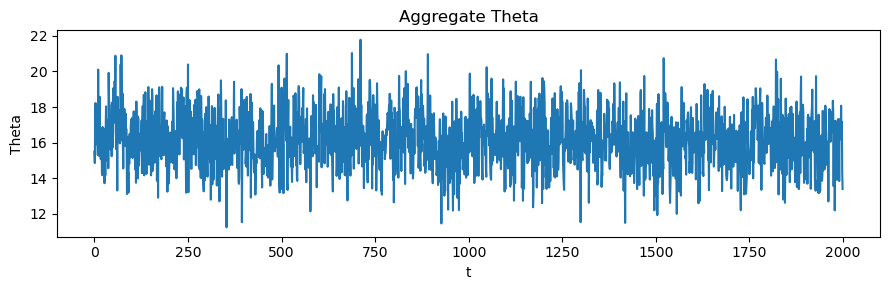

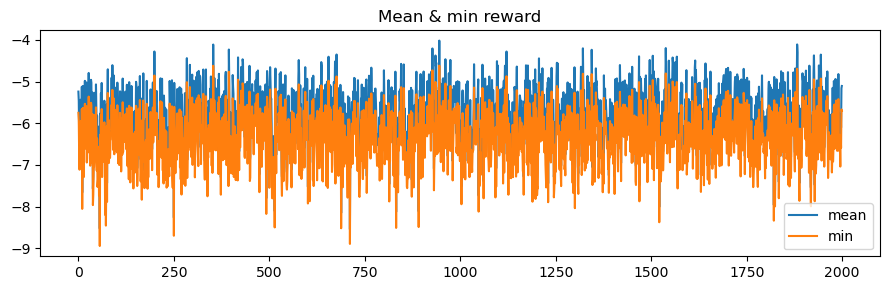

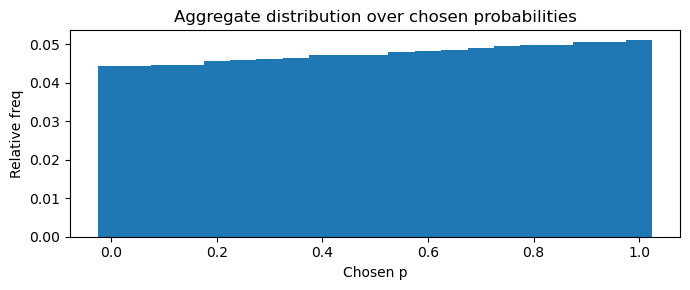

ValueError: operands could not be broadcast together with shapes (4,30) (21,) 

In [5]:
SEED = 9000
N = 30
C = int(0.6 * N)             # capacity
G, S, F = 5.0, 2.0, 0.1      # payoffs: attend uncrowded, stay home, attend crowded
rho = 0.1
alpha = 1.3
beta = 0.5
theta_max = 1e4
bar_theta = 1.0
k_init = 0.05                # initial uniform Q range

M = 10                       # discretization (actions = 0..M => p in {0,1/M,...,1})
ACTIONS = list(range(M+1))

lr = 0.05
gamma = 0.3
tau = 3.0
T_steps = 2000
n_seeds = 4

# ---------------- HELPERS ----------------
def attendance_bin(att): return min(att, C)
def theta_bin(theta):
    if theta <= 0: return 0
    b = int(math.floor(math.log10(theta)))
    return min(max(b,0),6)
def make_state(att, Theta, last_prob_idx):
    return (attendance_bin(att), theta_bin(Theta), last_prob_idx)
def softmax_probs(q_vals, tau):
    q = np.array(q_vals, dtype=float)
    z = q / tau
    z = z - np.max(z)
    expz = np.exp(z)
    return expz / np.sum(expz)
def stage_payoff(action_attend, total_attendance):
    if action_attend == 1:
        return G if (total_attendance - 1) < C else F
    else:
        return S

# ---------------- RUN SINGLE SEED ----------------
def run_seed(seed):
    random.seed(seed); np.random.seed(seed+7)
    Q = defaultdict(lambda: np.array([random.uniform(0,k_init) for _ in ACTIONS], dtype=float))
    last_prob_idx = [random.choice(ACTIONS) for _ in range(N)]
    last_actual = [1 if random.random() < (idx/M) else 0 for idx in last_prob_idx]
    theta = [bar_theta if a==0 else 0.0 for a in last_actual]
    Theta = sum(theta); A = sum(last_actual)
    state = [make_state(A, Theta, last_prob_idx[i]) for i in range(N)]
    attend_counts = np.zeros(N, dtype=int)
    chosen_prob_counts = np.zeros((N, M+1), dtype=int)
    logA = np.zeros(T_steps); logTheta = np.zeros(T_steps)
    logMeanR = np.zeros(T_steps); logMinR = np.zeros(T_steps)

    for t in range(T_steps):
        prob_indices = [0]*N
        chosen_probs = [0.0]*N
        # choose discrete-prob action via softmax over Q[state]
        for i in range(N):
            qvals = Q[state[i]]
            probs = softmax_probs(qvals, tau)
            idx = np.random.choice(ACTIONS, p=probs)
            prob_indices[i] = idx
            chosen_probs[i] = idx / M
            chosen_prob_counts[i, idx] += 1
        # sample actual attendance decisions
        actions = [1 if random.random() < chosen_probs[i] else 0 for i in range(N)]
        A = sum(actions)
        # update theta (based on actual last attendance)
        new_theta = [0.0]*N
        for i in range(N):
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta[i] if theta[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_max)
            elif actions[i] == 0 and last_actual[i] == 1:
                new_theta[i] = bar_theta
            else:
                new_theta[i] = 0.0
        theta = new_theta; Theta = sum(theta)
        # rewards and Q updates
        rewards = np.zeros(N)
        for i in range(N):
            r = stage_payoff(actions[i], A) - beta * Theta
            rewards[i] = r
            next_state = make_state(A, Theta, prob_indices[i])
            old_q = Q[state[i]][prob_indices[i]]
            max_next = np.max(Q[next_state])
            Q[state[i]][prob_indices[i]] = old_q + lr * (r + gamma * max_next - old_q)
        attend_counts += np.array(actions)
        last_actual = actions[:]
        last_prob_idx = prob_indices[:]
        state = [make_state(A, Theta, last_prob_idx[i]) for i in range(N)]
        logA[t] = A; logTheta[t] = Theta; logMeanR[t] = rewards.mean(); logMinR[t] = rewards.min()

    return {'logA': logA, 'logTheta': logTheta, 'logMeanR': logMeanR, 'logMinR': logMinR,
            'attend_counts': attend_counts, 'chosen_prob_counts': chosen_prob_counts, 'Q': Q}

# ---------------- EXPERIMENT ----------------
def experiment():
    seeds = [SEED + 13*i for i in range(n_seeds)]
    runs = []
    t0 = time.time()
    for s in seeds:
        print("Running seed", s)
        runs.append(run_seed(s))
    print("Elapsed", time.time()-t0)
    # aggregate and plot
    logA = np.vstack([r['logA'] for r in runs]); meanA = logA.mean(axis=0); seA = logA.std(axis=0, ddof=1)/math.sqrt(n_seeds)
    logTheta = np.vstack([r['logTheta'] for r in runs]); meanTheta = logTheta.mean(axis=0)
    logMeanR = np.vstack([r['logMeanR'] for r in runs]); meanMeanR = logMeanR.mean(axis=0)
    logMinR = np.vstack([r['logMinR'] for r in runs]); meanMinR = logMinR.mean(axis=0)
    attend_counts = np.vstack([r['attend_counts'] for r in runs])
    chosen_counts = np.stack([r['chosen_prob_counts'] for r in runs])  # shape (seeds, N, M+1)

    # Plot attendance time series
    plt.figure(figsize=(9,3))
    plt.plot(meanA, label='Mean attendance'); plt.fill_between(range(T_steps), meanA-seA, meanA+seA, alpha=0.2)
    plt.axhline(C, linestyle='--', color='gray', label='Capacity C'); plt.legend()
    plt.title('Mean attendance'); plt.xlabel('t'); plt.ylabel('Attendance'); plt.tight_layout(); plt.show()

    # Plot Theta
    plt.figure(figsize=(9,3))
    plt.plot(meanTheta); plt.title('Aggregate Theta'); plt.xlabel('t'); plt.ylabel('Theta'); plt.tight_layout(); plt.show()

    # Mean & min reward
    plt.figure(figsize=(9,3))
    plt.plot(meanMeanR, label='mean'); plt.plot(meanMinR, label='min'); plt.legend()
    plt.title('Mean & min reward'); plt.tight_layout(); plt.show()

    # Empirical distribution over chosen probs (aggregate)
    total_counts = chosen_counts.sum(axis=0).sum(axis=0)  # shape (M+1,)
    p_vals = np.arange(M+1)/M
    rel_freq = total_counts / total_counts.sum()
    plt.figure(figsize=(7,3))
    plt.bar(p_vals, rel_freq, width=1.0/M, align='center')
    plt.xlabel('Chosen p'); plt.ylabel('Relative freq'); plt.title('Aggregate distribution over chosen probabilities'); plt.tight_layout(); plt.show()

    # Per-agent average chosen probability histogram
    per_agent_probs = (chosen_counts.sum(axis=2) * np.arange(M+1)).sum(axis=1) / (M * T_steps * n_seeds)
    # the formula above yields per-seed aggregated; we simplify: compute per-agent average across seeds
    per_agent_probs = (chosen_counts.sum(axis=2).dot(np.arange(M+1))) / (M * T_steps)
    # If shape mismatch, flatten per-agent across seeds:
    flat_agent_probs = per_agent_probs.reshape(-1)
    plt.figure(figsize=(6,3))
    plt.hist(flat_agent_probs, bins=12)
    plt.xlabel('Agent average chosen p'); plt.ylabel('Count'); plt.title('Per-agent average chosen probability'); plt.tight_layout(); plt.show()

    # Save summary
    summary = {'params':{'N':N,'M':M,'tau':tau,'gamma':gamma,'lr':lr}, 'final_mean_att': float(meanA[-100:].mean())}
    with open('discrete_prob_actions_summary.json','w') as f:
        json.dump(summary,f, indent=2)
    print("Saved summary to discrete_prob_actions_summary.json")

SEED = 9000
N = 30
C = int(0.6 * N)             # capacity
G, S, F = 3.0, 2.0, 0.0      # payoffs: attend uncrowded, stay home, attend crowded
rho = 0.1
alpha = 1.3
beta = 0.5
theta_max = 1e4
bar_theta = 1.0
k_init = 0.05                # initial uniform Q range

M = 20                       # discretization (actions = 0..M => p in {0,1/M,...,1})
ACTIONS = list(range(M+1))

lr = 0.05
gamma = 0.3
tau = 1.0
T_steps = 2000
n_seeds = 4

# ---------------- HELPERS ----------------
def attendance_bin(att): return min(att, C)
def theta_bin(theta):
    if theta <= 0: return 0
    b = int(math.floor(math.log10(theta)))
    return min(max(b,0),6)
def make_state(att, Theta, last_prob_idx):
    return (attendance_bin(att), theta_bin(Theta), last_prob_idx)
def softmax_probs(q_vals, tau):
    q = np.array(q_vals, dtype=float)
    z = q / tau
    z = z - np.max(z)
    expz = np.exp(z)
    return expz / np.sum(expz)
def stage_payoff(action_attend, total_attendance):
    if action_attend == 1:
        return G if (total_attendance - 1) < C else F
    else:
        return S

# ---------------- RUN SINGLE SEED ----------------
def run_seed(seed):
    random.seed(seed); np.random.seed(seed+7)
    Q = defaultdict(lambda: np.array([random.uniform(0,k_init) for _ in ACTIONS], dtype=float))
    last_prob_idx = [random.choice(ACTIONS) for _ in range(N)]
    last_actual = [1 if random.random() < (idx/M) else 0 for idx in last_prob_idx]
    theta = [bar_theta if a==0 else 0.0 for a in last_actual]
    Theta = sum(theta); A = sum(last_actual)
    state = [make_state(A, Theta, last_prob_idx[i]) for i in range(N)]
    attend_counts = np.zeros(N, dtype=int)
    chosen_prob_counts = np.zeros((N, M+1), dtype=int)
    logA = np.zeros(T_steps); logTheta = np.zeros(T_steps)
    logMeanR = np.zeros(T_steps); logMinR = np.zeros(T_steps)

    for t in range(T_steps):
        prob_indices = [0]*N
        chosen_probs = [0.0]*N
        # choose discrete-prob action via softmax over Q[state]
        for i in range(N):
            qvals = Q[state[i]]
            probs = softmax_probs(qvals, tau)
            idx = np.random.choice(ACTIONS, p=probs)
            prob_indices[i] = idx
            chosen_probs[i] = idx / M
            chosen_prob_counts[i, idx] += 1
        # sample actual attendance decisions
        actions = [1 if random.random() < chosen_probs[i] else 0 for i in range(N)]
        A = sum(actions)
        # update theta (based on actual last attendance)
        new_theta = [0.0]*N
        for i in range(N):
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta[i] if theta[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_max)
            elif actions[i] == 0 and last_actual[i] == 1:
                new_theta[i] = bar_theta
            else:
                new_theta[i] = 0.0
        theta = new_theta; Theta = sum(theta)
        # rewards and Q updates
        rewards = np.zeros(N)
        for i in range(N):
            r = stage_payoff(actions[i], A) - beta * Theta
            rewards[i] = r
            next_state = make_state(A, Theta, prob_indices[i])
            old_q = Q[state[i]][prob_indices[i]]
            max_next = np.max(Q[next_state])
            Q[state[i]][prob_indices[i]] = old_q + lr * (r + gamma * max_next - old_q)
        attend_counts += np.array(actions)
        last_actual = actions[:]
        last_prob_idx = prob_indices[:]
        state = [make_state(A, Theta, last_prob_idx[i]) for i in range(N)]
        logA[t] = A; logTheta[t] = Theta; logMeanR[t] = rewards.mean(); logMinR[t] = rewards.min()

    return {'logA': logA, 'logTheta': logTheta, 'logMeanR': logMeanR, 'logMinR': logMinR,
            'attend_counts': attend_counts, 'chosen_prob_counts': chosen_prob_counts, 'Q': Q}

# ---------------- EXPERIMENT ----------------
def experiment():
    seeds = [SEED + 13*i for i in range(n_seeds)]
    runs = []
    t0 = time.time()
    for s in seeds:
        print("Running seed", s)
        runs.append(run_seed(s))
    print("Elapsed", time.time()-t0)
    # aggregate and plot
    logA = np.vstack([r['logA'] for r in runs]); meanA = logA.mean(axis=0); seA = logA.std(axis=0, ddof=1)/math.sqrt(n_seeds)
    logTheta = np.vstack([r['logTheta'] for r in runs]); meanTheta = logTheta.mean(axis=0)
    logMeanR = np.vstack([r['logMeanR'] for r in runs]); meanMeanR = logMeanR.mean(axis=0)
    logMinR = np.vstack([r['logMinR'] for r in runs]); meanMinR = logMinR.mean(axis=0)
    attend_counts = np.vstack([r['attend_counts'] for r in runs])
    chosen_counts = np.stack([r['chosen_prob_counts'] for r in runs])  # shape (seeds, N, M+1)

    # Plot attendance time series
    plt.figure(figsize=(9,3))
    plt.plot(meanA, label='Mean attendance'); plt.fill_between(range(T_steps), meanA-seA, meanA+seA, alpha=0.2)
    plt.axhline(C, linestyle='--', color='gray', label='Capacity C'); plt.legend()
    plt.title('Mean attendance'); plt.xlabel('t'); plt.ylabel('Attendance'); plt.tight_layout(); plt.show()

    # Plot Theta
    plt.figure(figsize=(9,3))
    plt.plot(meanTheta); plt.title('Aggregate Theta'); plt.xlabel('t'); plt.ylabel('Theta'); plt.tight_layout(); plt.show()

    # Mean & min reward
    plt.figure(figsize=(9,3))
    plt.plot(meanMeanR, label='mean'); plt.plot(meanMinR, label='min'); plt.legend()
    plt.title('Mean & min reward'); plt.tight_layout(); plt.show()

    # Empirical distribution over chosen probs (aggregate)
    total_counts = chosen_counts.sum(axis=0).sum(axis=0)  # shape (M+1,)
    p_vals = np.arange(M+1)/M
    rel_freq = total_counts / total_counts.sum()
    plt.figure(figsize=(7,3))
    plt.bar(p_vals, rel_freq, width=1.0/M, align='center')
    plt.xlabel('Chosen p'); plt.ylabel('Relative freq'); plt.title('Aggregate distribution over chosen probabilities'); plt.tight_layout(); plt.show()

    # Per-agent average chosen probability histogram
    per_agent_probs = (chosen_counts.sum(axis=2) * np.arange(M+1)).sum(axis=1) / (M * T_steps * n_seeds)
    # the formula above yields per-seed aggregated; we simplify: compute per-agent average across seeds
    per_agent_probs = (chosen_counts.sum(axis=2).dot(np.arange(M+1))) / (M * T_steps)
    # If shape mismatch, flatten per-agent across seeds:
    flat_agent_probs = per_agent_probs.reshape(-1)
    plt.figure(figsize=(6,3))
    plt.hist(flat_agent_probs, bins=12)
    plt.xlabel('Agent average chosen p'); plt.ylabel('Count'); plt.title('Per-agent average chosen probability'); plt.tight_layout(); plt.show()

    # Save summary
    summary = {'params':{'N':N,'M':M,'tau':tau,'gamma':gamma,'lr':lr}, 'final_mean_att': float(meanA[-100:].mean())}
    with open('discrete_prob_actions_summary.json','w') as f:
        json.dump(summary,f, indent=2)
    print("Saved summary to discrete_prob_actions_summary.json")

if __name__ == "__main__":
    experiment()

C:\Users\katja\AppData\Local\Temp\ipykernel_27036\1116122854.py:111: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


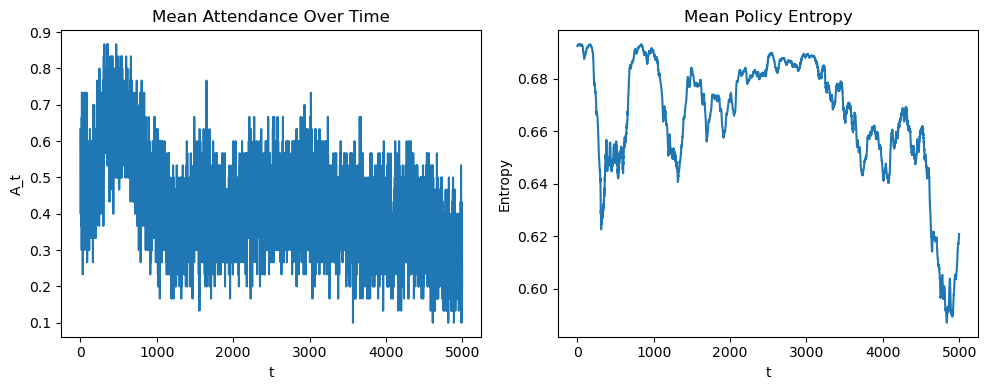

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Hyperparameters ====
N = 30                  # number of agents
T = 5000                # timesteps
gamma = 0.9             # discount
lr_actor = 3e-4
lr_critic = 1e-3
lambda_entropy = 0.05
beta_punish = 0.8       # strength of punishment
rho, alpha = 0.05, 1.4  # punishment growth params

device = "cpu"
C = 0.6

# ==== Environment ====
def env_step(a, theta_prev):
    A = np.mean(a)
    
    # piecewise congestion reward
    if A < C:
        base_reward = 1.0      # corresponds to G
    else:
        base_reward = 0.3      # corresponds to F
    
    # apply punishment and aggregate dynamics
    theta_new = np.clip(theta_prev + rho * (theta_prev ** alpha) + beta_punish * (A ** 2), 0, 5.0)
    r = base_reward - theta_new
    return r, theta_new

# ==== Networks ====
class Actor(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, s):
        return torch.sigmoid(self.net(s))  # probability of attending

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, s):
        return self.net(s)

# ==== Initialize ====
state_dim = 2  # [A_{t-1}, theta_{t-1}]
actor = Actor(state_dim).to(device)
critic = Critic(state_dim).to(device)
opt_actor = optim.Adam(actor.parameters(), lr=lr_actor)
opt_critic = optim.Adam(critic.parameters(), lr=lr_critic)

# ==== Simulation loop ====
A_hist, entropy_hist = [], []
theta = 0.1
A_prev = 0.5

for t in range(T):
    # Normalized, stable state
    s = torch.tensor([[A_prev, min(theta, 5.0) / 5.0]], dtype=torch.float32).repeat(N, 1)

    # Compute probabilities and clamp
    probs = torch.clamp(actor(s).squeeze(), 1e-6, 1 - 1e-6)
    dist = torch.distributions.Bernoulli(probs)

    a = dist.sample()
    logp = dist.log_prob(a)
    entropy = dist.entropy().mean()
    A = a.mean().item()

    r, theta_new = env_step(a.numpy(), theta)
    reward = torch.tensor(r, dtype=torch.float32).mean()

    s_next = torch.tensor([[A, theta_new]], dtype=torch.float32).repeat(N, 1)
    with torch.no_grad():
        V_next = critic(s_next).mean()
    V = critic(s).mean()
    delta = reward + gamma * V_next - V

    # Critic update
    opt_critic.zero_grad()
    (0.5 * delta.pow(2)).backward()
    opt_critic.step()

    # Actor update
    opt_actor.zero_grad()
    actor_loss = -(logp.mean() * delta.detach() + lambda_entropy * entropy)
    actor_loss.backward()
    opt_actor.step()

    A_hist.append(A)
    entropy_hist.append(entropy.item())

    A_prev, theta = A, theta_new

# ==== Plots ====
plt.figure(figsize=(10,4))
plt.axhline(C, linestyle='--', color='gray', label='Capacity C'); plt.legend()
plt.subplot(1,2,1)
plt.plot(A_hist)
plt.title("Mean Attendance Over Time")
plt.xlabel("t"); plt.ylabel("A_t")

plt.subplot(1,2,2)
plt.plot(entropy_hist)
plt.title("Mean Policy Entropy")
plt.xlabel("t"); plt.ylabel("Entropy")
plt.tight_layout()
plt.show()
